# Libraries

In [1]:
from pathlib import Path
import numpy as np, pandas as pd, json

from IPython.display import display, Markdown
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve

from pathlib import Path
import json, numpy as np, pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from pathlib import Path
import numpy as np, pandas as pd, json
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve, f1_score, confusion_matrix,
    roc_auc_score, average_precision_score
)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import (
    RocCurveDisplay, 
    PrecisionRecallDisplay, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.metrics import (
    RocCurveDisplay, PrecisionRecallDisplay,
    confusion_matrix, ConfusionMatrixDisplay
)


from sklearn.base import clone
from sklearn.cluster import KMeans, MiniBatchKMeans, FeatureAgglomeration
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, adjusted_rand_score, confusion_matrix, make_scorer, f1_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import make_scorer, adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler,normalize
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from scipy import sparse
from scipy import sparse as sp
import scipy.stats as stats
from scipy.stats import kstest

import warnings

import os
from collections import OrderedDict
import time

from sklearn.calibration import CalibratedClassifierCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Functions

In [2]:
def save_benchmarks(bench_type,bench_data):
    global REPORT
    bench_data.to_csv(f"{REPORT}/benchmark_model_history.csv", index=False)

In [3]:
def print_results(title,pipe, X_test, y_test, thr_star):

    # Préparation des 3 sous-graphes côte à côte
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Courbe ROC
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=axs[0])
    axs[0].set_title(f"Courbe ROC - {title}")
    axs[0].grid(True)

    # Courbe Précision-Rappel
    PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test, ax=axs[1])
    axs[1].set_title(f"Courbe Précision-Rappel - {title}")
    axs[1].grid(True)

    # Matrice de confusion avec seuil choisi
    proba_test = pipe.predict_proba(X_test)[:, 1]
    y_pred_thr = (proba_test >= thr_star).astype(int)
    cm = confusion_matrix(y_test, y_pred_thr)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Risque", "Risque"])
    disp.plot(ax=axs[2], cmap="Blues", values_format="d", colorbar=False)
    axs[2].set_title("Matrice de confusion - Seuil métier (FN=10xFP)")
    axs[2].grid(False)

    plt.tight_layout()
    plt.show()

In [16]:
def benchmark_final_models(
    bench_name,
    X,
    y,
    cv=5,
    random_state=42,
    cost_fn=10.0,
    cost_fp=1.0,
    baseline_model="LogisticRegression",
    run_bench=True,
    tune_linear_svc=False,    # False par défaut ; mets True si tu veux vraiment le tester
):
    """
    Benchmark modèles :
      - Nested CV UNIQUEMENT pour les modèles qui ont un petit tuning (GridSearchCV).
      - StandardScaler auto (with_mean=False si sparse).
      - Scores: accuracy, macro-F1, ARI.
      - Stocke les résultats dans 'benchmark_model_trace' (créé si absent).
    """
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            category=FutureWarning,
            module=r"sklearn\.linear_model\._logistic"   # ne masque que ces warnings-là
        )
        

    # -------- préparation du DataFrame des résultats
    cols = [
        "ID","Bench_name","Tested","Model_type",
        "Features","Rows","Seuil","recall_mean", "TP","FP","TN","FN","Cost",
        "Cost_std","Cost_rate_mean","Cost_rate_std","Cost_per_1k_mean","Cost_per_1k_std",
        "Accuracy_mean","Accuracy_std","F1_mean","F1_std","ARI_mean","ARI_std",
        "Time_mean"
    ]
        
    display(Markdown(f"### <b><u>Benchmark models (nested CV) - {bench_name}: {X.shape[1]} Features</u></b>"))

# Schéma par défaut
    DEFAULT_MODEL_COLS = [
        "ID","Bench_name","Tested","Model_type",
        "Features","Rows","Seuil","recall_mean", "TP","FP","TN","FN", "Cost",
        "Cost_std","Cost_rate_mean","Cost_rate_std","Cost_per_1k_mean","Cost_per_1k_std",
        "Accuracy_mean","Accuracy_std","F1_mean","F1_std","ARI_mean","ARI_std",
        "Time_mean"
    ]
           
    

    def _expected_cols(df):
        """Renvoie la liste de colonnes à utiliser (DF existant sinon défaut)."""
        if isinstance(df, pd.DataFrame) and not df.empty:
            return list(df.columns)
        return DEFAULT_MODEL_COLS

    # --- initialisation robuste du benchmark_model_trace
    global benchmark_model_trace
    try:
        expected_cols = _expected_cols(benchmark_model_trace)
        # s'assure que toutes les colonnes attendues existent
        for c in expected_cols:
            if c not in benchmark_model_trace.columns:
                benchmark_model_trace[c] = np.nan
    except NameError:
        expected_cols = DEFAULT_MODEL_COLS
        benchmark_model_trace = pd.DataFrame(columns=expected_cols)

    # -------- early exit (mode affichage seulement)
    if not run_bench:
        res = benchmark_model_trace[benchmark_model_trace["Bench_name"] == bench_name] \
                .sort_values(by="F1_mean", ascending=False)[
                    ['Model_type','Tested','Rows','Cost',"Cost_std", "Cost_rate_mean", "Cost_rate_std", "Cost_per_1k_mean", "Cost_per_1k_std",'FN','FP','recall_mean','Seuil','Time_mean']]        
        plot_benchmark_results(res, cv=cv, cost_fn=cost_fn, cost_fp=cost_fp, baseline_model=baseline_model)
        return

    # -------- CV objets
    if isinstance(cv, int):
        os.environ["PYTHONWARNINGS"] = "ignore:.*(multi_class|liblinear).*:FutureWarning:sklearn.linear_model._logistic"
        cv_outer = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        n_folds = cv
    else:
        cv_outer = cv
        n_folds = cv.get_n_splits()

    os.environ["PYTHONWARNINGS"] = "ignore:.*(multi_class|liblinear).*:FutureWarning:sklearn.linear_model._logistic"
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)  # inner pour GridSearch

    # -------- Scaler & imputer auto
    is_sparse = sp.issparse(X) or getattr(X, "sparse", None) is not None
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler(with_mean=False) if is_sparse else StandardScaler()

    # -------- score ARI
    ari_scorer = make_scorer(adjusted_rand_score)
    scoring = {"acc": "accuracy", "f1": "f1_macro", "ari": ari_scorer}

    # -------- helper pour nester seulement si on a un param_grid
    def nester(estimator, param_grid=None):
        if param_grid is None:
            return estimator
        os.environ["PYTHONWARNINGS"] = "ignore:.*(multi_class|liblinear).*:FutureWarning:sklearn.linear_model._logistic"
        return GridSearchCV(
            estimator, param_grid,
            cv=cv_inner, scoring="f1_macro",
            n_jobs=-1, refit=True
        )

    # -------- catalogue de modèles
    models = OrderedDict()

    # LogisticRegression (tuning léger) – plus de warning
    models["LogisticRegression"] = nester(
        Pipeline([
            ("imp", imputer),
            ("scale", scaler),
            ("clf", LogisticRegression(max_iter=2000, solver="saga", random_state=random_state))
        ]),
        {"clf__C": [0.5, 1, 2], "clf__class_weight": [None, "balanced"]}
    )

    # LinearSVC (seulement si demandé ET si peu de features)
    if tune_linear_svc and X.shape[1] <= 500:
        models["LinearSVC"] = nester(
            Pipeline([
                    ("imp", imputer),
                    ("scale", scaler),
                    ("clf", LinearSVC(max_iter=5000, random_state=random_state))]),
            {"clf__C": [0.5, 1, 2], "clf__class_weight": [None, "balanced"]}
        )

    # Modèles sans tuning (direct)
    models["RandomForest"] = nester(Pipeline([
                                    ("imp", imputer),
                                    ("clf", RandomForestClassifier(n_estimators=300, random_state=random_state, n_jobs=-1))]))
    models["GradientBoosting"] = nester(Pipeline([
                                    ("imp", imputer),
                                    ("clf", GradientBoostingClassifier(random_state=random_state))]))
    models["MLP"] = nester(Pipeline([
                                    ("imp", imputer),
                                    ("scale", scaler),
                                    ("clf", MLPClassifier(max_iter=1000, random_state=random_state))]))
    models["KNN"] = nester(Pipeline([
                                    ("imp", imputer),
                                    ("scale", scaler),
                                    ("clf", KNeighborsClassifier(n_neighbors=5))]))
    models["LightGBM"] = nester(Pipeline([
                                    ("imp", imputer),
                                    ("clf", LGBMClassifier(random_state=random_state, n_jobs=-1,class_weight="balanced"))]))    
    
    pos = int(y.sum())
    neg = int(len(y) - pos)
    scale_pos_weight = (neg / pos) if pos > 0 else 1.0

    models["XGBoost"] = nester(Pipeline([
                                    ("imp", imputer),
                                    ("clf", XGBClassifier(random_state=random_state, n_jobs=-1, tree_method="hist",eval_metric="logloss",scale_pos_weight=scale_pos_weight))]))
        
    # -------- boucle des modèles
    new_rows = []
    for name, est in models.items():
        t0 = time.perf_counter()
        # IMPORTANT : outer en série pour éviter le parallélisme imbriqué
        scores = cross_validate(est, X, y, cv=cv_outer, scoring=scoring, return_estimator=True,
                                return_train_score=False, n_jobs=1, error_score=np.nan)
        
        # --- métriques "coût" par fold (FN=10x, FP=1x)
        COST_FN, COST_FP = 10.0, 1.0
        tp_sum = tn_sum = fp_sum = fn_sum = 0
        thr_list, cost_list, recall_folds,fold_sizes = [], [], [], []

        for (tr_idx, te_idx), est in zip(cv_outer.split(X, y), scores["estimator"]):
            X_te = X.iloc[te_idx] if hasattr(X, "iloc") else X[te_idx]
            y_te = y[te_idx]
            fold_sizes.append(len(y_te))

            # X_tr / y_tr du fold courant
            X_tr = X.iloc[tr_idx] if hasattr(X, "iloc") else X[tr_idx]
            y_tr = y[tr_idx]

            # Calibrage isotonic sur le TRAIN du fold (pas de fuite)
            cal = CalibratedClassifierCV(estimator=est, method="isotonic", cv=cv)
            cal.fit(X_tr, y_tr)

            # Scores calibrés sur le TEST du fold
            s = cal.predict_proba(X_te)[:, 1]

            # seuil min-coût sur ce fold
            thr_grid = np.unique(np.round(s, 6))
            if len(thr_grid) > 4096:
                thr_grid = np.quantile(s, np.linspace(0, 1, 4096))
                
            best_t, best_c = 0.5, float("inf")
            for t in thr_grid:
                pred = (s >= t).astype(int)
                tn, fp, fn, tp = confusion_matrix(y_te, pred, labels=[0, 1]).ravel()
                c = COST_FN*fn + COST_FP*fp
                if c < best_c:
                    best_c, best_t = c, float(t)

            # confusion au meilleur seuil de CE fold
            pred = (s >= best_t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_te, pred, labels=[0, 1]).ravel()
            rec = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            recall_folds.append(rec)

            tn_sum += int(tn);fp_sum += int(fp); fn_sum += int(fn); tp_sum += int(tp)
            thr_list.append(best_t); cost_list.append(best_c)

        elapsed = (time.perf_counter() - t0) / n_folds

        long_name = f"{name} ({X.shape[0]},{X.shape[1]})"
        
        cost_arr = np.array(cost_list, dtype=float)
        cost_rate = cost_arr / np.array(fold_sizes, dtype=float)

        row = {
            "ID": f"{len(benchmark_model_trace)}_{bench_name}",
            "Bench_name": bench_name,
            "Tested": f"{name} ({X.shape[0]},{X.shape[1]})",
            "Model_type": name,
            "Features": X.shape[1],
            "Rows": X.shape[0],
            "Seuil": float(np.mean(thr_list)),   # moyenne des seuils par fold
            "recall_mean": float(np.nanmean(recall_folds)),
            "TP": int(tp_sum),
            "TN": int(tn_sum),
            "FP": int(fp_sum),
            "FN": int(fn_sum),
            "Cost": float(np.nanmean(cost_arr)),
            "Cost_std": float(np.nanstd(cost_arr, ddof=1)),       # <— écart-type (échantillon)
            "Cost_rate_mean": float(np.nanmean(cost_rate)),
            "Cost_rate_std": float(np.nanstd(cost_rate, ddof=1)),
            "Cost_per_1k_mean": float(np.nanmean(cost_rate*1000)),
            "Cost_per_1k_std": float(np.nanstd(cost_rate*1000, ddof=1)),
            "Accuracy_mean": np.nanmean(scores['test_acc']),
            "Accuracy_std": np.nanstd(scores['test_acc']),
            "F1_mean": np.nanmean(scores['test_f1']),
            "F1_std": np.nanstd(scores['test_f1']),
            "ARI_mean": np.nanmean(scores['test_ari']),
            "ARI_std": np.nanstd(scores['test_ari']),
            "Time_mean": elapsed,
        }
        # complète les colonnes manquantes et impose l’ordre attendu
        for c in expected_cols:
            row.setdefault(c, np.nan)

        new_df = pd.DataFrame([row], columns=expected_cols)
        benchmark_model_trace = pd.concat([benchmark_model_trace, new_df], ignore_index=True)

    res = benchmark_model_trace[benchmark_model_trace["Bench_name"] == bench_name] \
            .sort_values(by="F1_mean", ascending=False)[
                ['Model_type','Tested','Rows','Cost',"Cost_std", "Cost_rate_mean", "Cost_rate_std", "Cost_per_1k_mean", "Cost_per_1k_std",'FN','FP','recall_mean','Seuil','Time_mean']]

    # Si tu as une fonction utilitaire locale
    try:
        save_benchmarks("model", benchmark_model_trace)
    except Exception:
        pass

    plot_benchmark_results(res, cv=cv, cost_fn=cost_fn, cost_fp=cost_fp, baseline_model=baseline_model)


In [5]:
def plot_benchmark_results(
    df_results, cv=3, cost_fn=10.0, cost_fp=1.0,
    baseline_model="LogisticRegression",
    top_n=None, top_k_decomp=5, show_table=True
):
    if df_results is None or len(df_results) == 0:
        print("Aucun résultat."); return

    df = df_results.copy()
    df["label"] = (df["Model_type"] if "Model_type" in df.columns else df["Tested"]).astype(str)

    rows = df["Rows"].astype(float)
    fold_size = rows / float(cv)
    df["cost_per_case"]   = df["Cost"].astype(float) / fold_size
    df["cost_per_1k"]     = df["cost_per_case"] * 1000.0
    df["cost_std_per_1k"] = (df.get("Cost_std", np.nan).astype(float) / fold_size) * 1000.0
    df["fp_per_1k"]       = float(cost_fp) * (df["FP"].astype(float) / rows) * 1000.0
    df["fn_per_1k"]       = float(cost_fn) * (df["FN"].astype(float) / rows) * 1000.0

    df = df.sort_values("cost_per_1k", ascending=True).reset_index(drop=True)
    if top_n is not None:
        df = df.head(top_n)

    baseline_cost_1k, base_idx = None, None
    try:
        base_idx = df.index[df["label"].str.contains(str(baseline_model), case=False, na=False)][0]
        baseline_cost_1k = float(df.loc[base_idx, "cost_per_1k"])
    except Exception:
        pass

    x = np.arange(len(df))
    DARK_RED = "#C62828"

    plt.rcParams.update({"axes.titlesize":11, "axes.labelsize":10, "xtick.labelsize":9, "ytick.labelsize":9})
    fig, axs = plt.subplots(1, 3, figsize=(19, 5.6), constrained_layout=True)

    # (1) Coût/1000 + Temps
    axc = axs[0]
    axc.bar(x, df["fp_per_1k"], label="FP (par 1000)")
    axc.bar(x, df["fn_per_1k"], bottom=df["fp_per_1k"], label="FN (par 1000)", color=DARK_RED)
    axc.errorbar(x, df["cost_per_1k"], yerr=df["cost_std_per_1k"], fmt="none", ecolor="k", capsize=3, alpha=0.6)
    if baseline_cost_1k is not None:
        axc.axhline(baseline_cost_1k, ls="--", lw=1, alpha=0.7, label=f"Baseline: {baseline_model}")
    axc.set_xticks(x); axc.set_xticklabels(df["label"], rotation=18, ha="right")
    axc.set_ylabel("Coût par 1000 dossiers"); axc.set_title("Coût / 1000 + Temps")
    axc.grid(True, axis="y", alpha=0.2); axc.margins(x=0.05)

    axt = axc.twinx()
    axt.plot(x, df["Time_mean"].astype(float).values, color="black", marker="o", lw=1.6, label="Temps (s)", alpha=0.9)
    axt.set_ylabel("Temps moyen CV (s)")
    h1,l1 = axc.get_legend_handles_labels(); h2,l2 = axt.get_legend_handles_labels()
    axs[0].legend(h1+h2, l1+l2, loc="upper center", bbox_to_anchor=(0.5, 1.22),
                  ncol=3, frameon=False, columnspacing=1.2, handlelength=1.6)

    # (2) Pareto coût vs rappel (zoom + vignette correctement ancrée)
    axp = axs[1]
    cost = df["cost_per_1k"].to_numpy()
    rec  = df["recall_mean"].astype(float).to_numpy()

    if baseline_cost_1k is not None:
        axp.axhspan(0, baseline_cost_1k*0.95, color="green", alpha=0.08, label="-5% baseline")
        axp.axhline(baseline_cost_1k, ls="--", lw=1, alpha=0.7, color="gray", label="Coût baseline")

    axp.scatter(rec, cost, s=55, alpha=0.75)

    idx_min_cost = int(np.argmin(cost)) if len(cost) else None
    idx_max_rec  = int(np.argmax(rec))  if len(rec)  else None
    to_annot = {idx_min_cost, idx_max_rec}
    if base_idx is not None: to_annot.add(int(base_idx))
    to_annot.discard(None)
    offsets = {idx_min_cost:(8,10), idx_max_rec:(8,-10)}
    if base_idx is not None and int(base_idx) not in offsets:
        offsets[int(base_idx)] = (8,0)
    for idx in to_annot:
        axp.annotate(df["label"].iat[idx], (rec[idx], cost[idx]),
                     textcoords="offset points", xytext=offsets.get(idx,(8,8)),
                     ha="left", va="center", fontsize=8,
                     bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.85),
                     arrowprops=dict(arrowstyle='-', color='0.3', lw=0.8), clip_on=False)

    # zoom (montre un bout du -5%)
    qx1,qx2 = np.quantile(rec,[0.10,0.90]); qy1,qy2 = np.quantile(cost,[0.10,0.90])
    pad_x = 0.04*max(qx2-qx1,1e-3); pad_y = 0.08*max(qy2-qy1,1e-3)
    ymin = qy1 - pad_y
    if baseline_cost_1k is not None:
        ymin = min(ymin, baseline_cost_1k*0.95 - 0.02*(qy2-qy1))
    axp.set_xlim(qx1 - pad_x, qx2 + pad_x)
    axp.set_ylim(ymin, qy2 + pad_y)
    axp.set_xlabel("Rappel moyen"); axp.set_ylabel("Coût par 1000")
    axp.set_title(f"Pareto: Coût / 1000 vs Rappel (cv={cv})")
    axp.grid(True, alpha=0.2); axp.margins(x=0.06, y=0.10)
    axp.legend(loc="upper right", frameon=False)

    # --- Vignette "Vue complète" (position fixée dans l'axe)
    # [x0, y0, width, height] en coordonnées de l'axe (0..1)
    x0, y0, w, h = 0.06, 0.61, 0.33, 0.33   # ↓ baisse en diminuant y0 (ex : 0.45)
    axins = axp.inset_axes([x0, y0, w, h])

    axins.set_facecolor("white")
    axins.scatter(rec, cost, s=20, alpha=0.65)
    if baseline_cost_1k is not None:
        axins.axhline(baseline_cost_1k, ls="--", lw=0.8, color="gray", alpha=0.7)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_title("Vue complète", fontsize=8, pad=6)

    # (3) Décomposition coût – Top 5
    axd = axs[2]
    topk = df.nsmallest(top_k_decomp, "cost_per_1k")
    xt = np.arange(len(topk))
    axd.bar(xt, topk["fp_per_1k"], label="FP (par 1000)")
    axd.bar(xt, topk["fn_per_1k"], bottom=topk["fp_per_1k"], label="FN (par 1000)", color=DARK_RED)
    axd.set_xticks(xt); axd.set_xticklabels(topk["label"].values, rotation=18, ha="right")
    axd.set_ylabel("Coût par 1000 dossiers"); axd.set_title(f"Décomposition coût – Top {len(topk)}")
    axd.grid(True, axis="y", alpha=0.2)
    leg = axd.legend(loc="upper right", bbox_to_anchor=(0.98,0.98),
                     frameon=True, fancybox=True, borderpad=0.4, fontsize=9)
    leg.get_frame().set_alpha(0.65); leg.get_frame().set_facecolor("white")
    leg.get_frame().set_edgecolor("0.35"); leg.get_frame().set_linewidth(0.8)

    plt.show()

    if show_table:
        cols = ["label","cost_per_1k","cost_std_per_1k","recall_mean","F1_mean","Time_mean","Seuil","FN","FP"]
        cols = [c for c in cols if c in df.columns]
        display(df[cols].rename(columns={"label":"Model","F1_mean":"F1","Time_mean":"Time(s)"}))


In [6]:
def plot_benchmark_results_acc_F1(df_results, tested_type, cv=5, top_n=10):
    """
    Affiche 2 graphiques :
      1) Accuracy/F1 sur axe principal + leurs std sur axe secondaire
      2) Temps moyen (Time_mean)
    Filtre automatiquement les lignes avec NaN/Inf avant tracé.
    """

    # Filtre sûr : on ne garde que les lignes où les métriques sont finies
    keep = np.isfinite(df_results["Accuracy_mean"]) & np.isfinite(df_results["F1_mean"])
    keep &= np.isfinite(df_results["Accuracy_std"]) & np.isfinite(df_results["F1_std"])
    keep &= np.isfinite(df_results["Time_mean"])
    df_results = df_results.loc[keep].copy()

    if df_results.empty:
        print("Rien à tracer : aucune ligne avec des scores valides.")
        return

    df_results = df_results.head(top_n)

    sns.set_style("whitegrid")
    x = np.arange(len(df_results))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()

    # Moyennes sur ax1
    ax1.bar(x - width/2, df_results["Accuracy_mean"], width, label="Accuracy_mean", color="#608FF4")
    ax1.bar(x + width/2, df_results["F1_mean"], width, label="F1_mean", color="#65CC99")

    # Std sur ax2
    ax2.plot(x, df_results["Accuracy_std"], 'o--', color="#E37813", label="Accuracy_std")
    ax2.plot(x, df_results["F1_std"], 'o--', color="#DCD61B", label="F1_std")

    v1 = np.r_[df_results["Accuracy_mean"].values, df_results["F1_mean"].values]
    v1 = v1[np.isfinite(v1)]
    if v1.size:
        lo, hi = v1.min(), v1.max()
        pad = 0.05 * (hi - lo if hi > lo else max(1e-6, abs(hi)))
        ax1.set_ylim(max(0.0, lo - pad), min(1.0, hi + pad))

    v2 = np.r_[df_results["Accuracy_std"].values, df_results["F1_std"].values]
    v2 = v2[np.isfinite(v2)]
    if v2.size:
        lo, hi = v2.min(), v2.max()
        pad = 0.10 * (hi - lo if hi > lo else max(1e-9, abs(hi)))
        ax2.set_ylim(max(0.0, lo - pad), hi + pad)


    # Axes
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_results["Tested"], rotation=30)
    ax1.set_title(f"Benchmark {tested_type} (cv={cv})")
    ax1.set_ylabel("Score")
    ax2.set_ylabel("std")

    # Fusion des légendes
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right")

    ax2.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
    ax2.grid(False)  # pas de grille sur l’axe std

    plt.show()

    # --- 2) Temps ---
    plt.figure(figsize=(8, 4))
    sns.barplot(x="Tested", y="Time_mean", data=df_results, color="#DF5757")
    plt.ylabel("Secondes")
    plt.title("Temps moyen de cross-validation (s)")
    plt.xticks(rotation=30)
    plt.show()

In [7]:
def bench_loaded(bench_type,bench_name):
    
    global benchmark_reducer_trace
    global benchmark_model_trace

    result = True

    match bench_type:
        case "model":
            bench=benchmark_model_trace
        case _:
            bench = None
            result = False

    if result:
        if len(bench[bench["Bench_name"] == bench_name])>0:
            result = False
        else:
            result = True
    
    return result

# 02 - Model

In [8]:
# Dossiers
ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT / "data" / "processed"
CFG  = ROOT / "config"; CFG.mkdir(exist_ok=True)
REPORT  = ROOT / "reports"; REPORT.mkdir(exist_ok=True)

In [18]:
# Chargement de l'historique des benchmarks (models)
try:
    benchmark_model_trace = pd.read_csv(f"{REPORT}/benchmark_model_history.csv")
except:
    benchmark_model_trace = pd.DataFrame(columns=["ID","Bench_name","Tested","Model_type","Features","Rows","Seuil","recall_mean","TP","FP","TN","FN","Cost","Cost_std", "Cost_rate_mean", "Cost_rate_std", "Cost_per_1k_mean", "Cost_per_1k_std","Accuracy_mean","Accuracy_std","F1_mean","F1_std", 'ARI_mean', 'ARI_std',"Time_mean"])

In [10]:
# 1) Charger le dataset enrichi v1
df = pd.read_csv(PROC / "train_features_v1.csv")

In [11]:
# 2) Choisir les features disponibles (compteurs + nouvelles)
feat_wishlist = [
    'n_bureau', 'n_bureau_months', 'n_prev', 'n_inst_pay',
    'n_pos_cash', 'n_ccb', 'n_prev_apps', 'credit_income_perc',
    'annuity_income_perc', 'goods_price_income_perc', 'age_years',
    'employed_years', 'ext1', 'ext2', 'ext3', 'cnt_children',
    'cnt_family_members', 'is_new_to_credit'
]
feat_cols = [c for c in feat_wishlist if c in df.columns]
X = df[feat_cols].astype(float)
y = df["TARGET"].astype(int).values
print("Features utilisées:", feat_cols, f"| nb features: {len(feat_cols)} | Positifs:", int(y.sum()))

# 3) Split stratifié
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4) Pipeline simple + LogReg pondérée
pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
pipe.fit(Xtr, ytr)
proba = pipe.predict_proba(Xva)[:,1]

# 5) Seuil qui minimise le coût métier (FN=10xFP)
_, _, thr = precision_recall_curve(yva, proba)
ths = np.r_[0.0, thr, 1.0]

costs = []
for t in ths:
    pred_t = (proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(yva, pred_t).ravel()
    costs.append(10*fn + fp)

best_i   = int(np.argmin(costs))
best_thr = float(ths[best_i])
pred     = (proba >= best_thr).astype(int)

# 6) Résumé clair
tn, fp, fn, tp = confusion_matrix(yva, pred).ravel()
print(f"Seuil (coût min)   : {best_thr:.3f} | Coût = {costs[best_i]}")
print(f"F1 @ seuil (coût)  : {f1_score(yva, pred):.3f}")
print(f"PR-AUC             : {average_precision_score(yva, proba):.3f}")
print(f"ROC-AUC            : {roc_auc_score(yva, proba):.3f}")
print("Erreurs :  TP=",tp," | FP=",fp," | FN=",fn," | TN=",tn)

# 7) Sauvegardes pour suivi/plots
(pd.DataFrame({"TARGET": yva, "proba": proba})
   .to_csv(PROC / "val_proba_baseline_v2.csv", index=False))
with open(CFG / "threshold_v2.json","w") as f:
    json.dump({"threshold": best_thr, "features": feat_cols}, f)
print("\nÉcrits :", PROC / "val_proba_baseline_v2.csv", "et", CFG / "threshold_v2.json")


Features utilisées: ['n_bureau', 'n_bureau_months', 'n_prev', 'n_inst_pay', 'n_pos_cash', 'n_ccb', 'n_prev_apps', 'credit_income_perc', 'annuity_income_perc', 'goods_price_income_perc', 'age_years', 'employed_years', 'ext1', 'ext2', 'ext3', 'cnt_children', 'cnt_family_members', 'is_new_to_credit'] | nb features: 18 | Positifs: 24825
Seuil (coût min)   : 0.513 | Coût = 34649
F1 @ seuil (coût)  : 0.255
PR-AUC             : 0.216
ROC-AUC            : 0.733
Erreurs :  TP= 3174  | FP= 16739  | FN= 1791  | TN= 39799

Écrits : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_scoring\data\processed\val_proba_baseline_v2.csv et c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_scoring\config\threshold_v2.json


In [12]:
# Étape 8 – Rapport clair avec le seuil choisi (minimisation du coût)

# Données de validation (probas)
df = pd.read_csv(PROC / "val_proba_baseline_v2.csv")
y = df["TARGET"].astype(int).values
p = df["proba"].values

# Paramètres de coût et seuil
thr_path = CFG / "threshold_v2.json"
if thr_path.exists():
    cfg = json.load(open(thr_path, "r", encoding="utf-8"))
    best_thr = float(cfg.get("threshold"))
    fn_cost  = float(cfg.get("fn_cost", 10.0))
    fp_cost  = float(cfg.get("fp_cost", 1.0))
else:
    fn_cost, fp_cost = 10.0, 1.0
    thr = np.unique(np.round(p, 6))
    if len(thr) > 4096:
        thr = np.quantile(p, np.linspace(0, 1, 4096))
    costs = []
    for t in thr:
        pred_t = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred_t, labels=[0, 1]).ravel()
        costs.append(fn_cost * fn + fp_cost * fp)
    i = int(np.argmin(costs))
    best_thr = float(thr[i])

# Prédictions et métriques au seuil min-coût
pred = (p >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y, pred, labels=[0, 1]).ravel()
prec_v = precision_score(y, pred, zero_division=0)
rec_v  = recall_score(y, pred)
f1_v   = f1_score(y, pred)
min_cost = fn_cost * fn + fp_cost * fp

print(f"Seuil utilisé (min cost) : {best_thr:.3f}")
print(f"Précision        : {prec_v:.3f}")
print(f"Rappel           : {rec_v:.3f}")
print(f"F1               : {f1_v:.3f}")
print(f"Coût (FNx{fn_cost:.0f} + FPx{fp_cost:.0f}) : {min_cost:.0f}")
print(f"TP:{tp} | FP:{fp} | FN:{fn} | TN:{tn}")
print(f"Positifs={int(y.sum())} | Négatifs={len(y)-int(y.sum())}")

# Sauvegarde d’un mini-rapport texte
report = (
    f"Seuil(min_cost): {best_thr:.3f}\n"
    f"Précision: {prec_v:.3f} | Rappel: {rec_v:.3f} | F1: {f1_v:.3f}\n"
    f"Coût(FNx{fn_cost:.0f}+FPx{fp_cost:.0f}): {min_cost:.0f}\n"
    f"TP:{tp} FP:{fp} FN:{fn} TN:{tn}\n"
    f"Positifs:{int(y.sum())} | Négatifs:{len(y)-int(y.sum())}\n"
)

out = PROC / "baseline_v2_report.txt"
open(out, "w", encoding="utf-8").write(report)
print(f"Écrit : {out}")

Seuil utilisé (min cost) : 0.513
Précision        : 0.159
Rappel           : 0.639
F1               : 0.255
Coût (FNx10 + FPx1) : 34649
TP:3174 | FP:16739 | FN:1791 | TN:39799
Positifs=4965 | Négatifs=56538
Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_scoring\data\processed\baseline_v2_report.txt


ROC-AUC: 0.734 | PR-AUC: 0.217
Seuil min-coût: 0.461 | Coût: 34544


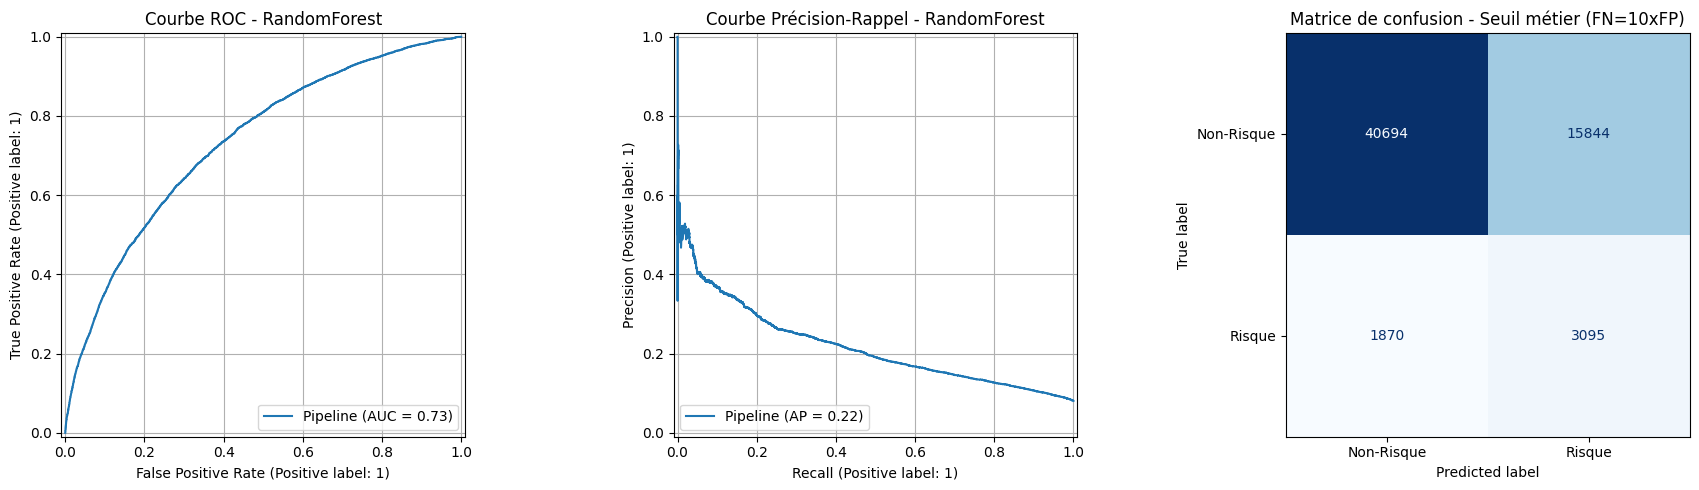

In [13]:
# RandomForest simple — objectif : minimiser le coût (FN=10×FP)

from pathlib import Path
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

# 1) Données
ROOT = Path.cwd() if (Path.cwd() / "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT / "data" / "processed"
df = pd.read_csv(PROC / "train_features_v1.csv")

feat_whishlist = [
    'n_bureau','n_bureau_months','n_prev','n_inst_pay','n_pos_cash','n_ccb',
    'credit_income_perc','annuity_income_perc','goods_price_income_perc',
    'age_years','employed_years','ext1','ext2','ext3',
    'cnt_children','cnt_family_members','n_prev_apps','is_new_to_credit'
]
feat_cols = [c for c in feat_whishlist if c in df.columns]
X = df[feat_cols].astype(float)
y = df['TARGET'].astype(int).values

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Pipeline (impute + RF)
pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=400, max_depth=12, random_state=42,
        class_weight="balanced", n_jobs=-1
    ))
])
pipe.fit(X_train, y_train)

# 4) Scores globaux (sans seuil)
proba_test = pipe.predict_proba(X_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, proba_test):.3f} | PR-AUC: {average_precision_score(y_test, proba_test):.3f}")

# 5) Recherche du seuil min-coût
COST_FN, COST_FP = 10.0, 1.0
thr_grid = np.unique(np.round(proba_test, 6))
if len(thr_grid) > 4096:
    thr_grid = np.quantile(proba_test, np.linspace(0, 1, 4096))

best_thr, best_cost = 0.5, float("inf")
for t in thr_grid:
    y_pred = (proba_test >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    cost = COST_FN*fn + COST_FP*fp
    if cost < best_cost:
        best_cost, best_thr = cost, float(t)

print(f"Seuil min-coût: {best_thr:.3f} | Coût: {best_cost:.0f}")

# 6) Visualisation standard (ROC, PR, Matrice au seuil choisi)
print_results("RandomForest", pipe, X_test, y_test, best_thr)


### <b><u>Benchmark models (nested CV) - 01 - vs. Baseline_A: 11 Features</u></b>

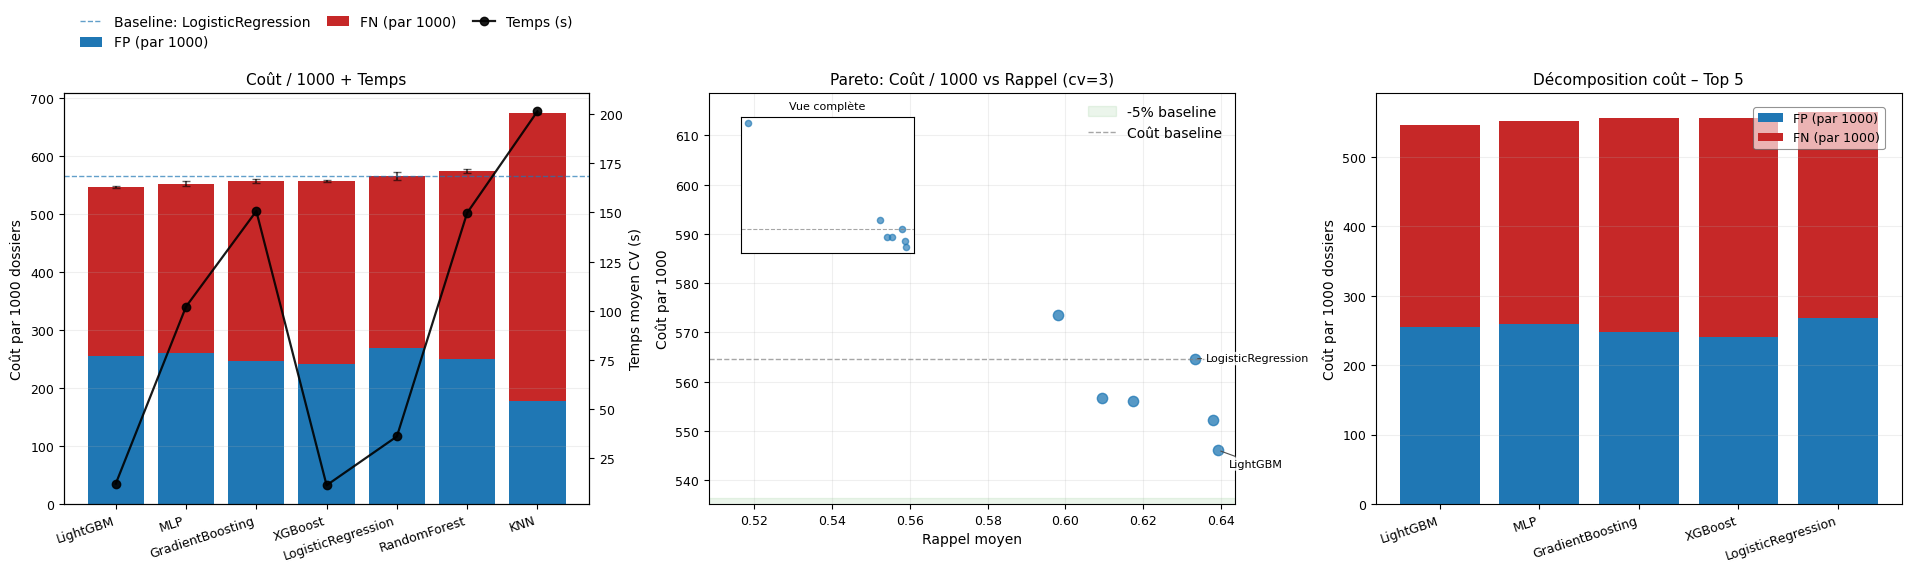

,Model,cost_per_1k,cost_std_per_1k,recall_mean,Time(s),Seuil,FN,FP
0,LightGBM,546.113798,1.521219,0.639235,12.195240,0.087488,8956,78376
1,MLP,552.165614,3.986402,0.637986,102.164285,0.088349,8987,79927
2,GradientBoosting,556.093928,3.137354,0.617321,150.672479,0.091561,9500,76005
3,XGBoost,556.747564,1.339679,0.609305,11.396760,0.091921,9699,74216
4,LogisticRegression,564.698499,6.713106,0.633273,36.179008,0.088894,9104,82611
5,RandomForest,573.618505,3.843975,0.598066,149.760200,0.089764,9978,76614
6,KNN,673.501111,1.563519,0.386385,201.342784,0.094990,15233,54779


In [20]:
feat_whishlist = [
    'credit_income_perc','annuity_income_perc','goods_price_income_perc',
    'age_years','employed_years','ext1','ext2','ext3',
    'cnt_children','cnt_family_members','is_new_to_credit'
]
feat_cols = [c for c in feat_whishlist if c in df.columns]
X = df[feat_cols].astype(float)
y = df['TARGET'].astype(int).values

bench_title="01 - vs. Baseline_A"
run_bench=bench_loaded("model",bench_title)
source_feature=X

benchmark_final_models(
    bench_title,
    source_feature,
    y,
    run_bench=run_bench,
    cv=3
)

del bench_title,X,y,source_feature,run_bench

### <b><u>Benchmark models (nested CV) - 01 - vs. Baseline: 18 Features</u></b>

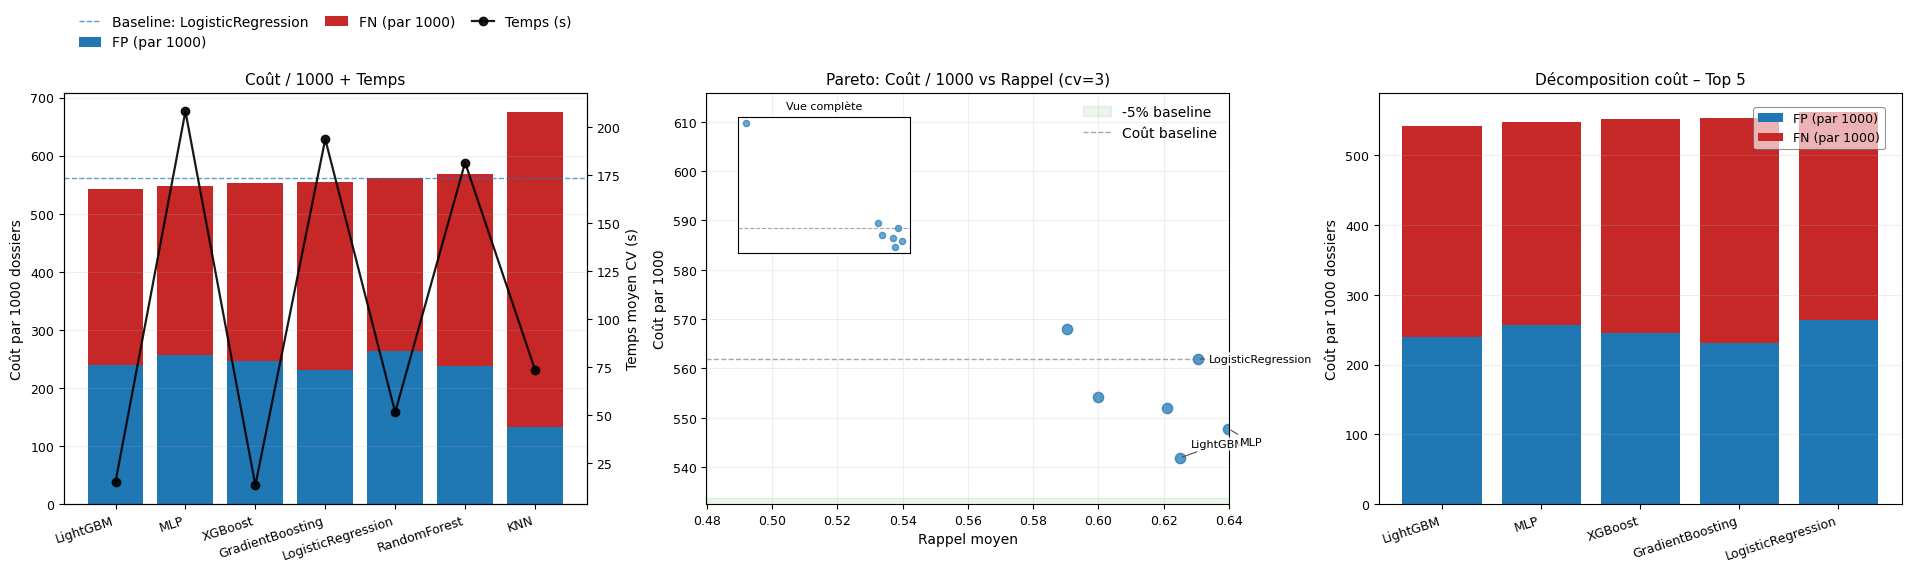

,Model,cost_per_1k,cost_std_per_1k,recall_mean,Time(s),Seuil,FN,FP
0,LightGBM,541.840780,NaN,0.624935,15.105431,0.091033,9311,73512
1,MLP,547.798290,NaN,0.639839,207.954615,0.088750,8941,79044
2,XGBoost,551.931476,NaN,0.620906,13.364745,0.089587,9411,75615
3,GradientBoosting,554.243588,NaN,0.600000,193.463358,0.093779,9930,71136
4,LogisticRegression,561.924614,NaN,0.630413,51.356894,0.088622,9175,81048
5,RandomForest,568.067484,NaN,0.590413,181.301403,0.091211,10168,73007
6,KNN,674.632777,NaN,0.328822,73.498180,0.093918,16662,40837


In [ ]:
feat_whishlist = [
    'n_bureau','n_bureau_months','n_prev','n_inst_pay','n_pos_cash','n_ccb',
    'credit_income_perc','annuity_income_perc','goods_price_income_perc',
    'age_years','employed_years','ext1','ext2','ext3',
    'cnt_children','cnt_family_members','n_prev_apps','is_new_to_credit'
]
feat_cols = [c for c in feat_whishlist if c in df.columns]
X = df[feat_cols].astype(float)
y = df['TARGET'].astype(int).values

bench_title="01 - vs. Baseline_B"
run_bench=bench_loaded("model",bench_title)
source_feature=X

benchmark_final_models(
    bench_title,
    source_feature,
    y,
    run_bench=run_bench,
    cv=3
)

del bench_title,X,y,source_feature,run_bench

In [41]:
from pathlib import Path
from datetime import datetime
import json, joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import set_config

# LightGBM (assure-toi que lightgbm est installé)
from lightgbm import LGBMClassifier


def run_final_eval(
    model_name: str,
    train_csv: Path,
    test_csv: Path | None = None,
    out_dir: Path | str = "models",
    cv = 3,
    features: list[str] | None = None,      # liste de colonnes à garder (optionnel)
    cost_fn: float = 10.0,
    cost_fp: float = 1.0,
    test_size: float = 0.10,
    random_state: int = 42,
):
    """
    Entraîne un modèle + calibration isotonic (cv=cv), applique le seuil métier fixe,
    évalue sur test (fichier si fourni, sinon lock test 10%), sauvegarde modèle & méta.

    model_name: "lightgbm" ou "mlp"
    """
    train_csv = Path(train_csv)
    test_csv  = Path(test_csv) if test_csv else None
    out_dir   = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)

    # -- données
    df = pd.read_csv(train_csv)
    y = df["TARGET"].astype(int).values
    X = df.drop(columns=[c for c in df.columns if c.upper() == "TARGET"])

    # -- features
    if features is None:
        features = X.select_dtypes(include=[np.number]).columns.tolist()
    X = X[features]

    # -- split test
    if test_csv and test_csv.exists():
        df_te = pd.read_csv(test_csv)
        y_te = df_te["TARGET"].astype(int).values
        X_te = df_te.drop(columns=[c for c in df_te.columns if c.upper()=="TARGET"])[features]
        X_tr, y_tr = X, y
        split_info = "TEST fichier"
    else:
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        split_info = f"lock test {int(test_size*100)}% (stratified)"

    # -- pipeline de base selon le modèle
    if model_name.lower() == "lightgbm":
        base = Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("clf", LGBMClassifier(
                objective="binary",
                n_estimators=500, learning_rate=0.05, num_leaves=31,
                n_jobs=-1, random_state=random_state
            )),
        ])
    elif model_name.lower() == "mlp":
        base = Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
            ("clf", MLPClassifier(max_iter=1000, random_state=random_state)),
        ])
    else:
        raise ValueError("model_name doit être 'lightgbm' ou 'mlp'.")

    # -- calibration isotonic en DERNIÈRE étape
    set_config(transform_output="pandas")  # garde les noms de colonnes après imputer/scale
    cv_cal = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv=cv_cal, n_jobs=-1)
    cal.fit(X_tr, y_tr)

    # -- seuil métier figé
    t_star = cost_fp / (cost_fp + cost_fn)

    proba = cal.predict_proba(X_te)[:, 1]
    y_pred = (proba >= t_star).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec  = recall_score(y_te, y_pred, zero_division=0)
    f1   = f1_score(y_te, y_pred, zero_division=0)

    cost = cost_fn*fn + cost_fp*fp
    cost_per_1k = cost / len(y_te) * 1000.0

    # -- sorties
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    model_path = out_dir / f"{model_name}_isotonic_{stamp}.pkl"
    joblib.dump(cal, model_path)

    meta = {
        "model": model_name,
        "version": stamp,
        "features": features,
        "threshold": float(t_star),
        "cost_fp": float(cost_fp),
        "cost_fn": float(cost_fn),
        "train_rows": int(len(y_tr)),
        "test_rows": int(len(y_te)),
        "split_info": split_info,
        "metrics": {
            "accuracy": float(acc), "precision": float(prec),
            "recall": float(rec), "f1": float(f1),
            "cost": float(cost), "cost_per_1k": float(cost_per_1k),
            "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn)
        },
        "files": {"train_csv": train_csv.name, "test_csv": test_csv.name if test_csv else None,
                  "model_path": model_path.name}
    }
    with open(out_dir / f"model_meta_{model_name}_{stamp}.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    pd.DataFrame({"proba": proba, "y_true": y_te, "y_pred": y_pred}) \
      .to_csv(out_dir / f"pred_{model_name}_{stamp}.csv", index=False)

    print(f"[{model_name}] {split_info} | train={len(y_tr)} | test={len(y_te)} | features={len(features)} | cv={str(cv)}")
    print(f"Seuil t*={t_star:.3f} | Coût={cost:.1f} | Coût/1000={cost_per_1k:.2f}")
    print(f"Acc:{acc:.3f}  Préc:{prec:.3f}  Rappel:{rec:.3f}  F1:{f1:.3f}")
    print(f"TP:{tp}  FP:{fp}  FN:{fn}  TN:{tn}")

    return {
        "model_name": model_name,
        "threshold": t_star,
        "metrics": meta["metrics"],
        "features": features,
        "model_path": str(model_path),
        "meta_path": str(out_dir / f"model_meta_{model_name}_{stamp}.json"),
    }


In [42]:
ROOT = Path.cwd() if (Path.cwd() / "data").exists() else Path.cwd().parent
PROC = ROOT / "data" / "processed"

res_lgbm = run_final_eval("lightgbm", PROC/"train_features_v1.csv", features=feat_whishlist)
print(" ")
res_mlp  = run_final_eval("mlp",       PROC/"train_features_v1.csv", features=feat_whishlist)

[lightgbm] lock test 10% (stratified) | train=276759 | test=30752 | features=11 | cv=3
Seuil t*=0.091 | Coût=16679.0 | Coût/1000=542.37
Acc:0.726  Préc:0.173  Rappel:0.631  F1:0.271
TP:1566  FP:7509  FN:917  TN:20760
 
[mlp] lock test 10% (stratified) | train=276759 | test=30752 | features=11 | cv=3
Seuil t*=0.091 | Coût=16622.0 | Coût/1000=540.52
Acc:0.724  Préc:0.172  Rappel:0.636  F1:0.271
TP:1579  FP:7582  FN:904  TN:20687


In [48]:
import time
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from sklearn import set_config

from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier


def cv_cost_eval(
    model_name: str,
    train_csv: str | Path,
    cv: int = 5,
    cost_fn: float = 10.0,
    cost_fp: float = 1.0,
    random_state: int = 42,
    features: list[str] | None = None,
):
    """
    CV externe (StratifiedKFold) pour coût métier.
    - pipeline: Imputer -> (Scaler si MLP) -> Modèle -> CalibratedClassifierCV(isotonic, cv=3)
    - seuil figé t* = cost_fp / (cost_fp + cost_fn)
    - retourne un résumé + les résultats par fold
    """
    train_csv = Path(train_csv)
    df = pd.read_csv(train_csv)

    y = df["TARGET"].astype(int).values
    X = df.drop(columns=[c for c in df.columns if c.upper() == "TARGET"])

    # colonnes utilisées
    if features is None:
        features = X.select_dtypes(include=[np.number]).columns.tolist()
    X = X[features]

    # pipeline selon le modèle
    name = model_name.lower()
    if name == "lightgbm":
        base = Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("clf", LGBMClassifier(
                objective="binary", n_estimators=500, learning_rate=0.05,
                num_leaves=31, n_jobs=-1, random_state=random_state
            )),
        ])
    elif name == "mlp":
        base = Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
            ("clf", MLPClassifier(max_iter=1000, random_state=random_state)),
        ])
    else:
        raise ValueError("model_name doit être 'lightgbm' ou 'mlp'.")

    # garder DataFrame dans le pipeline (évite les warnings de noms)
    set_config(transform_output="pandas")

    outer = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    t_star = cost_fp / (cost_fp + cost_fn)

    rows = []
    for k, (tr_idx, te_idx) in enumerate(outer.split(X, y), start=1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        # calibration isotonic en dernière étape (cv=3 interne)
        cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv=3, n_jobs=-1)

        t0 = time.perf_counter()
        cal.fit(X_tr, y_tr)
        proba = cal.predict_proba(X_te)[:, 1]
        y_pred = (proba >= t_star).astype(int)
        elapsed = time.perf_counter() - t0

        tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0, 1]).ravel()
        cost = cost_fn * fn + cost_fp * fp
        cost_per_1k = cost / len(y_te) * 1000.0

        rec = recall_score(y_te, y_pred, zero_division=0)
        f1  = f1_score(y_te, y_pred, zero_division=0)

        rows.append({
            "fold": k, "n_test": int(len(y_te)),
            "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
            "recall": float(rec), "f1": float(f1),
            "cost": float(cost), "cost_per_1k": float(cost_per_1k),
            "time_s": float(elapsed),
        })

    df_folds = pd.DataFrame(rows)
    summary = {
        "model": model_name,
        "cv": cv,
        "threshold": float(t_star),
        "cost_per_1k_mean": float(df_folds["cost_per_1k"].mean()),
        "cost_per_1k_std": float(df_folds["cost_per_1k"].std(ddof=1)),
        "recall_mean": float(df_folds["recall"].mean()),
        "recall_std": float(df_folds["recall"].std(ddof=1)),
        "f1_mean": float(df_folds["f1"].mean()),
        "f1_std": float(df_folds["f1"].std(ddof=1)),
        "time_mean_s": float(df_folds["time_s"].mean()),
        "n": int(len(y)),
    }

    print(f"[{model_name} | CV={cv}]  "
          f"features = {len(features)}  "
          f"| coût/1000 = {summary['cost_per_1k_mean']:.2f} ± {summary['cost_per_1k_std']:.2f}  "
          f"| recall = {summary['recall_mean']:.3f} ± {summary['recall_std']:.3f}  "
          f"| f1 = {summary['f1_mean']:.3f} ± {summary['f1_std']:.3f}  "
          f"| temps moyen/fold = {summary['time_mean_s']:.1f}s")

    return summary, df_folds


In [49]:
PROC = ROOT / "data" / "processed"

sum_lgbm, folds_lgbm = cv_cost_eval("lightgbm", PROC/"train_features_v1.csv", cv=5, features=feat_whishlist)
sum_mlp,  folds_mlp  = cv_cost_eval("mlp",       PROC/"train_features_v1.csv", cv=5, features=feat_whishlist)


[lightgbm | CV=5]  features = 11  | coût/1000 = 547.75 ± 7.02  | recall = 0.624 ± 0.010  | f1 = 0.268 ± 0.003  | temps moyen/fold = 8.4s
[mlp | CV=5]  features = 11  | coût/1000 = 550.99 ± 7.86  | recall = 0.624 ± 0.008  | f1 = 0.266 ± 0.004  | temps moyen/fold = 25.8s


In [37]:
from __future__ import annotations
from pathlib import Path
from datetime import datetime
import json, joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import set_config


def train_final_model(
    train_csv: str | Path,
    estimator,                           # <-- n'importe quel estimator sklearn compatible (ex : LGBMClassifier(), MLPClassifier(), LogisticRegression()…)
    *,
    model_name: str | None = None,       # tag dans les fichiers sauvegardés
    out_dir: str | Path = "models",
    features: list[str] | None = None,   # si None -> prend les colonnes numériques
    use_imputer: bool = True,
    imputer_strategy: str = "median",
    use_scaler: bool = False,            # True pour MLP / LR
    scaler: object | None = None,        # si None et use_scaler=True -> StandardScaler()
    # --- calibration ---
    calibration: str | None = "isotonic",   # "isotonic" | "sigmoid" | None
    cv_cal: int | StratifiedKFold = 5,      # CV interne pour la calibration
    # --- coût / seuil ---
    cost_fn: float = 10.0,
    cost_fp: float = 1.0,
    # --- évaluation optionnelle (lock-test) ---
    eval_test_size: float = 0.0,            # 0.0 = pas de lock-test ; ex: 0.10 = 10% pour tester
    random_state: int = 42,
    refit_full: bool = True,                # si lock-test, réentraîne sur 100% avant sauvegarde
):
    """
    Entraîne un pipeline (imputer/scale + estimator) éventuellement calibré,
    fige le seuil métier t* = cost_fp / (cost_fp + cost_fn),
    optionnellement fait un lock-test, sauvegarde modèle + méta.

    Retourne: dict avec paths, threshold, features, metrics (si lock-test).
    """
    train_csv = Path(train_csv)
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    set_config(transform_output="pandas")     # conserve les noms de colonnes dans le pipeline

    # --- data
    df = pd.read_csv(train_csv)
    y = df["TARGET"].astype(int).values
    X = df.drop(columns=[c for c in df.columns if c.upper() == "TARGET"])

    # --- features
    if features is None:
        features = X.select_dtypes(include=[np.number]).columns.tolist()
    X = X[features]

    # --- build pipeline
    steps = []
    if use_imputer:
        steps.append(("imp", SimpleImputer(strategy=imputer_strategy)))
    if use_scaler:
        steps.append(("scale", scaler if scaler is not None else StandardScaler()))
    steps.append(("clf", estimator))
    base = Pipeline(steps)

    # --- calibration wrapper
    if calibration in ("isotonic", "sigmoid"):
        cv_obj = StratifiedKFold(n_splits=cv_cal, shuffle=True, random_state=random_state) if isinstance(cv_cal, int) else cv_cal
        model = CalibratedClassifierCV(estimator=base, method=calibration, cv=cv_obj, n_jobs=-1)
    else:
        model = base

    # --- seuil métier
    threshold = float(cost_fp / (cost_fp + cost_fn))

    # --- lock-test optionnel
    metrics = None
    split_info = "no lock-test"
    if eval_test_size and eval_test_size > 0:
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=eval_test_size, random_state=random_state, stratify=y
        )
        split_info = f"lock test {int(eval_test_size*100)}% (stratified)"

        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_te)[:, 1]
        y_pred = (proba >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()
        acc  = accuracy_score(y_te, y_pred)
        prec = precision_score(y_te, y_pred, zero_division=0)
        rec  = recall_score(y_te, y_pred, zero_division=0)
        f1   = f1_score(y_te, y_pred, zero_division=0)
        cost = cost_fn*fn + cost_fp*fp
        cost_per_1k = cost / len(y_te) * 1000.0

        metrics = {
            "accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1),
            "cost": float(cost), "cost_per_1k": float(cost_per_1k),
            "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
            "test_rows": int(len(y_te))
        }

        # réentraînement complet si demandé
        if refit_full:
            model.fit(X, y)
            split_info += " + refit full"

    else:
        # entraînement full direct
        model.fit(X, y)

    # --- sauvegardes
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    tag = model_name or estimator.__class__.__name__.lower()
    model_path = out_dir / f"{tag}_final_{stamp}.pkl"
    joblib.dump(model, model_path)

    meta = {
        "model_tag": tag,
        "version": stamp,
        "features": features,
        "threshold": threshold,
        "cost_fp": float(cost_fp),
        "cost_fn": float(cost_fn),
        "train_rows": int(len(y)),
        "class_counts": {"neg": int((y==0).sum()), "pos": int((y==1).sum())},
        "files": {"train_csv": train_csv.name, "model_path": model_path.name},
        "calibration": calibration,
        "calibration_cv": (cv_cal if isinstance(cv_cal, int) else getattr(cv_cal, "n_splits", None)),
        "split_info": split_info,
        "metrics_lock_test": metrics,   # peut être None
        "random_state": random_state,
        "pipeline_steps": [name for name, _ in steps]
    }
    meta_path = out_dir / f"model_meta_{tag}_{stamp}.json"
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    print(f"✅ Saved: {model_path.name} | t*={threshold:.3f} | features={len(features)} | {split_info}")
    if metrics:
        print(f"Lock-test  Coût/1000={metrics['cost_per_1k']:.2f} | Rappel={metrics['recall']:.3f} | F1={metrics['f1']:.3f}")

    return {
        "model_path": str(model_path),
        "meta_path": str(meta_path),
        "threshold": threshold,
        "features": features,
        "metrics_lock_test": metrics,
    }


In [50]:
from pathlib import Path
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

PROC = ROOT / "data" / "processed"

res_lgbm = train_final_model(
    train_csv=PROC/"train_features_v1.csv",
    estimator=LGBMClassifier(objective="binary", n_estimators=500, learning_rate=0.05,
                             num_leaves=31, n_jobs=-1, random_state=42),
    model_name="lgbm",
    use_imputer=True, use_scaler=False,
    calibration="isotonic", cv_cal=5,
    cost_fn=10.0, cost_fp=1.0,
    eval_test_size=0.10,   # lock-test + refit full
    refit_full=True,
    features=feat_whishlist   # les 11 colonnes (sans SK_ID_CURR)
)


✅ Saved: lgbm_final_20250905-165406.pkl | t*=0.091 | features=11 | lock test 10% (stratified) + refit full
Lock-test  Coût/1000=540.09 | Rappel=0.634 | F1=0.272


In [51]:
from pathlib import Path
import json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedShuffleSplit


def make_model_report(
    model_path: str | Path,
    meta_path: str | Path,
    train_csv: str | Path,             # utilisé pour l'échantillon d'importance + matrice de conf
    out_dir: str | Path = "reports",
    sample_size: int = 20000,          # échantillon pour importance & conf (rapide)
    n_repeats: int = 5,                # nb de permutations
    scoring: str = "roc_auc",          # métrique pour permutation_importance
    random_state: int = 42,
):
    """
    Génère:
      - feature_importance.png (permutation importance)
      - confusion_matrix.png    (sur un échantillon avec le seuil figé)
      - model_report_*.md       (markdown “A4” avec chiffres clés)
    """
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

    # ---- charge modèle + méta
    model = joblib.load(model_path)
    meta  = json.load(open(meta_path, "r", encoding="utf-8"))
    feats = meta["features"]
    thr   = float(meta["threshold"])
    cost_fp, cost_fn = float(meta["cost_fp"]), float(meta["cost_fn"])

    # ---- données (échantillon stratifié)
    df = pd.read_csv(train_csv)
    y = df["TARGET"].astype(int).values
    X = df[feats]

    if sample_size and sample_size < len(df):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=random_state)
        # on prend 'test' comme sous-échantillon
        _, te_idx = next(sss.split(X, y))
        Xs, ys = X.iloc[te_idx], y[te_idx]
    else:
        Xs, ys = X, y

    # ---- importance par permutation (agnostique du modèle)
    pi = permutation_importance(
        model, Xs, ys,
        scoring=scoring, n_repeats=n_repeats, random_state=random_state, n_jobs=-1
    )
    imp = pd.DataFrame({"feature": feats, "importance": pi.importances_mean}) \
             .sort_values("importance", ascending=False) \
             .reset_index(drop=True)

    # ---- proba + confusion (avec seuil métier)
    proba = model.predict_proba(Xs)[:, 1]
    y_pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(ys, y_pred, labels=[0, 1]).ravel()
    cost = cost_fn*fn + cost_fp*fp
    cost_per_1k = cost / len(ys) * 1000.0

    # ---- Figure 1: top 20 importances
    topn = min(20, len(imp))
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    imp.head(topn).iloc[::-1].plot.barh(x="feature", y="importance", ax=ax1)
    ax1.set_title("Importance (permutation) — top 20")
    ax1.set_xlabel(f"gain ({scoring})")
    fig1.tight_layout()
    imp_path = out / "feature_importance.png"
    fig1.savefig(imp_path, dpi=150)
    plt.close(fig1)

    # ---- Figure 2: matrice de confusion (simple)
    fig2, ax2 = plt.subplots(figsize=(4.5, 4))
    mat = np.array([[tn, fp], [fn, tp]])
    im = ax2.imshow(mat, cmap="Blues")
    for (i, j), v in np.ndenumerate(mat):
        ax2.text(j, i, f"{v}", ha="center", va="center", fontsize=11)
    ax2.set_xticks([0, 1], labels=["Prévu: 0", "Prévu: 1"])
    ax2.set_yticks([0, 1], labels=["Réel: 0", "Réel: 1"])
    ax2.set_title(f"Matrice de confusion (seuil={thr:.3f})")
    fig2.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    fig2.tight_layout()
    cm_path = out / "confusion_matrix.png"
    fig2.savefig(cm_path, dpi=150)
    plt.close(fig2)

    # ---- Récup chiffres lock-test s’ils existent dans le méta
    lock = meta.get("metrics_lock_test")

    # ---- Markdown “A4”
    report_name = f"model_report_{meta['version']}.md"
    report_path = out / report_name

    lines = []
    lines += [f"# Rapport modèle — {meta['model_tag'].upper()} ({meta['version']})\n"]
    lines += ["## Paramètres clés\n"]
    lines += [
        f"- **Seuil figé**: `{thr:.3f}` (FN={cost_fn}×, FP={cost_fp}×)",
        f"- **Features**: {len(feats)}",
        f"- **Fichier train**: `{Path(train_csv).name}`",
        f"- **Échantillon importance**: {len(Xs)} dossiers\n",
    ]

    if lock:
        lines += ["## Lock-test (tenu à part)\n"]
        lines += [
            f"- Coût total: **{lock['cost']:.1f}**  |  **Coût/1000**: **{lock['cost_per_1k']:.2f}**",
            f"- Rappel: **{lock['recall']:.3f}**  |  Précision: **{lock['precision']:.3f}**  |  F1: **{lock['f1']:.3f}**",
            f"- TP={lock['tp']}  FP={lock['fp']}  FN={lock['fn']}  TN={lock['tn']}  (n={lock['test_rows']})\n",
        ]

    lines += ["## Échantillon interne (pour visuels)\n"]
    lines += [
        f"- Coût/1000 (échantillon): **{cost_per_1k:.2f}**  "
        f"(TP={tp}, FP={fp}, FN={fn}, TN={tn}, n={len(ys)})\n"
    ]
    lines += ["### Importances\n"]
    lines += [f"![Feature importance]({imp_path.name})\n"]
    lines += ["### Matrice de confusion\n"]
    lines += [f"![Confusion matrix]({cm_path.name})\n"]

    lines += ["## Top 20 features\n"]
    tab = imp.head(topn).copy()
    tab["importance"] = tab["importance"].round(6)
    lines += [tab.to_markdown(index=False), "\n"]

    with open(report_path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print(f"✅ Rapport écrit: {report_path}  |  Figures: {imp_path.name}, {cm_path.name}")
    return {
        "report_path": str(report_path),
        "feature_importance_png": str(imp_path),
        "confusion_png": str(cm_path),
    }


In [55]:
from pathlib import Path
# adapte ces deux chemins aux derniers fichiers générés
model_path = "models/lgbm_final_20250905-165406.pkl"
meta_path  = "models/model_meta_lgbm_20250905-165406.json"

PROC = ROOT / "data" / "processed"

make_model_report(
    model_path=model_path,
    meta_path=meta_path,
    train_csv=PROC/"train_features_v1.csv",
    out_dir="reports",
    sample_size=20000,
    n_repeats=5,
    scoring="roc_auc",
)

✅ Rapport écrit: reports\model_report_20250905-165406.md  |  Figures: feature_importance.png, confusion_matrix.png


{'report_path': 'reports\\model_report_20250905-165406.md',
 'feature_importance_png': 'reports\\feature_importance.png',
 'confusion_png': 'reports\\confusion_matrix.png'}